In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import psutil
import os
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, log_loss
)
import xgboost as xgb
import lightgbm as lgb

# Memory profiling
from memory_profiler import memory_usage

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")


Libraries loaded successfully


In [3]:
import sys
from pathlib import Path

# Get current notebook directory
try:
    # If running in Jupyter
    NOTEBOOK_DIR = Path().resolve()
except:
    # If running as script
    NOTEBOOK_DIR = Path(__file__).parent

print(f"📂 Working directory: {NOTEBOOK_DIR}")

# Define paths relative to notebook location
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR
DATA_PATH = PROJECT_ROOT / 'src' / 'data' / 'processed'
MODELS_PATH = PROJECT_ROOT / 'models'
RESULTS_PATH = NOTEBOOK_DIR / 'results' if NOTEBOOK_DIR.name == 'notebooks' else PROJECT_ROOT / 'notebooks' / 'results'

# Create results directory
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
print(f"✓ Results will be saved to: {RESULTS_PATH}")

# Try to find train data in multiple locations
possible_train_files = [
    DATA_PATH / 'train_processed.csv',
    PROJECT_ROOT / 'src' / 'data' / 'raw' / 'train.csv',
    PROJECT_ROOT / 'data' / 'raw' / 'train.csv',
    NOTEBOOK_DIR / 'train.csv',
    Path('train.csv')
]

train_file = None
for file_path in possible_train_files:
    if file_path.exists():
        train_file = file_path
        print(f"✓ Found training data at: {train_file}")
        break

if train_file is None:
    print("\n❌ ERROR: Training data not found!")
    print("\nSearched in:")
    for path in possible_train_files:
        print(f"  - {path}")
    print("\nPlease ensure train.csv or train_processed.csv exists in one of these locations")
    print("\nYou can download it from:")
    print("  https://www.kaggle.com/competitions/forest-cover-type-prediction/data")
    sys.exit(1)

# Load data
df = pd.read_csv(train_file)
print(f"✓ Data loaded: {df.shape}")
    
    # Separate features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']
    
    # Adjust labels to 0-based indexing
y = y - 1
    
print(f"✓ Features: {X.shape[1]}")
print(f"✓ Samples: {len(X)}")
print(f"✓ Classes: {y.nunique()}")

# %%
# Class distribution
print("\nClass Distribution:")
class_counts = y.value_counts().sort_index()
for class_idx, count in class_counts.items():
    percentage = (count / len(y)) * 100
    print(f"  Class {class_idx + 1}: {count:,} samples ({percentage:.2f}%)")


📂 Working directory: C:\Users\nikka\Downloads\ForestTypePredict\notebooks
✓ Results will be saved to: C:\Users\nikka\Downloads\ForestTypePredict\notebooks\results
✓ Found training data at: C:\Users\nikka\Downloads\ForestTypePredict\src\data\raw\train.csv
✓ Data loaded: (15120, 56)
✓ Features: 55
✓ Samples: 15120
✓ Classes: 7

Class Distribution:
  Class 1: 2,160 samples (14.29%)
  Class 2: 2,160 samples (14.29%)
  Class 3: 2,160 samples (14.29%)
  Class 4: 2,160 samples (14.29%)
  Class 5: 2,160 samples (14.29%)
  Class 6: 2,160 samples (14.29%)
  Class 7: 2,160 samples (14.29%)


In [4]:
xgb_params = {
    'n_estimators': 500,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'multi:softmax',
    'num_class': 7,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist'
}

# LightGBM configuration
lgb_params = {
    'n_estimators': 400,
    'num_leaves': 64,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'multiclass',
    'num_class': 7,
    'random_state': 42,
    'n_jobs': -1,
    'metric': 'multi_logloss',
    'verbosity': -1
}

print("✓ Model configurations defined")


✓ Model configurations defined


In [5]:
def evaluate_model_cv(model, X, y, cv=5, model_name="Model"):
    """
    Perform cross-validation and collect detailed metrics
    """
    print(f"\n{'='*70}")
    print(f"Evaluating {model_name} with {cv}-Fold Cross-Validation")
    print(f"{'='*70}")
    
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Metrics storage
    results = {
        'accuracy': [],
        'f1_macro': [],
        'f1_weighted': [],
        'train_time': [],
        'predict_time': [],
        'memory_peak': []
    }
    
    fold_predictions = []
    fold_true_labels = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n--- Fold {fold}/{cv} ---")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Training with time measurement
        start_time = time.time()
        
        # Memory profiling
        mem_before = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        model.fit(X_train, y_train)
        
        mem_after = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        train_time = time.time() - start_time
        
        # Prediction with time measurement
        start_time = time.time()
        y_pred = model.predict(X_val)
        predict_time = time.time() - start_time
        
        # Calculate metrics
        acc = accuracy_score(y_val, y_pred)
        f1_macro = f1_score(y_val, y_pred, average='macro')
        f1_weighted = f1_score(y_val, y_pred, average='weighted')
        
        # Store results
        results['accuracy'].append(acc)
        results['f1_macro'].append(f1_macro)
        results['f1_weighted'].append(f1_weighted)
        results['train_time'].append(train_time)
        results['predict_time'].append(predict_time)
        results['memory_peak'].append(mem_after - mem_before)
        
        # Store predictions for later analysis
        fold_predictions.extend(y_pred)
        fold_true_labels.extend(y_val)
        
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1 (macro): {f1_macro:.4f}")
        print(f"  F1 (weighted): {f1_weighted:.4f}")
        print(f"  Train time: {train_time:.2f}s")
        print(f"  Predict time: {predict_time:.4f}s")
        print(f"  Memory delta: {mem_after - mem_before:.2f} MB")
    
    # Summary statistics
    print(f"\n{'='*70}")
    print(f"{model_name} - Cross-Validation Summary")
    print(f"{'='*70}")
    print(f"Accuracy:       {np.mean(results['accuracy']):.4f} ± {np.std(results['accuracy']):.4f}")
    print(f"F1 (macro):     {np.mean(results['f1_macro']):.4f} ± {np.std(results['f1_macro']):.4f}")
    print(f"F1 (weighted):  {np.mean(results['f1_weighted']):.4f} ± {np.std(results['f1_weighted']):.4f}")
    print(f"Train time:     {np.mean(results['train_time']):.2f}s ± {np.std(results['train_time']):.2f}s")
    print(f"Predict time:   {np.mean(results['predict_time']):.4f}s ± {np.std(results['predict_time']):.4f}s")
    print(f"Memory peak:    {np.mean(results['memory_peak']):.2f} MB ± {np.std(results['memory_peak']):.2f} MB")
    
    return results, fold_predictions, fold_true_labels

# %%
# Initialize models
xgb_model = xgb.XGBClassifier(**xgb_params)
lgb_model = lgb.LGBMClassifier(**lgb_params)

# Evaluate XGBoost
xgb_results, xgb_preds, xgb_true = evaluate_model_cv(
    xgb_model, X, y, cv=5, model_name="XGBoost"
)

# Evaluate LightGBM
lgb_results, lgb_preds, lgb_true = evaluate_model_cv(
    lgb_model, X, y, cv=5, model_name="LightGBM"
)


Evaluating XGBoost with 5-Fold Cross-Validation

--- Fold 1/5 ---
  Accuracy: 0.8859
  F1 (macro): 0.8840
  F1 (weighted): 0.8840
  Train time: 6.49s
  Predict time: 0.0326s
  Memory delta: 139.70 MB

--- Fold 2/5 ---
  Accuracy: 0.8965
  F1 (macro): 0.8949
  F1 (weighted): 0.8949
  Train time: 4.67s
  Predict time: 0.0275s
  Memory delta: 6.27 MB

--- Fold 3/5 ---
  Accuracy: 0.8846
  F1 (macro): 0.8834
  F1 (weighted): 0.8834
  Train time: 4.96s
  Predict time: 0.0325s
  Memory delta: 4.90 MB

--- Fold 4/5 ---
  Accuracy: 0.8862
  F1 (macro): 0.8851
  F1 (weighted): 0.8851
  Train time: 4.85s
  Predict time: 0.0282s
  Memory delta: 12.86 MB

--- Fold 5/5 ---
  Accuracy: 0.8800
  F1 (macro): 0.8774
  F1 (weighted): 0.8774
  Train time: 4.86s
  Predict time: 0.0302s
  Memory delta: 6.40 MB

XGBoost - Cross-Validation Summary
Accuracy:       0.8866 ± 0.0054
F1 (macro):     0.8850 ± 0.0056
F1 (weighted):  0.8850 ± 0.0056
Train time:     5.16s ± 0.67s
Predict time:   0.0302s ± 0.0021s
Me


COMPARATIVE METRICS SUMMARY
   Model  Accuracy  Accuracy_std  F1_Macro  F1_Macro_std  Train_Time_s  Predict_Time_s  Memory_MB
 XGBoost  0.886640      0.005415  0.884956      0.005636      5.163503        0.030202  34.025781
LightGBM  0.893651      0.004390  0.892272      0.004502      4.980405        0.105477  -4.836719

✓ Metrics saved to: C:\Users\nikka\Downloads\ForestTypePredict\notebooks\results\model_comparison_metrics.csv


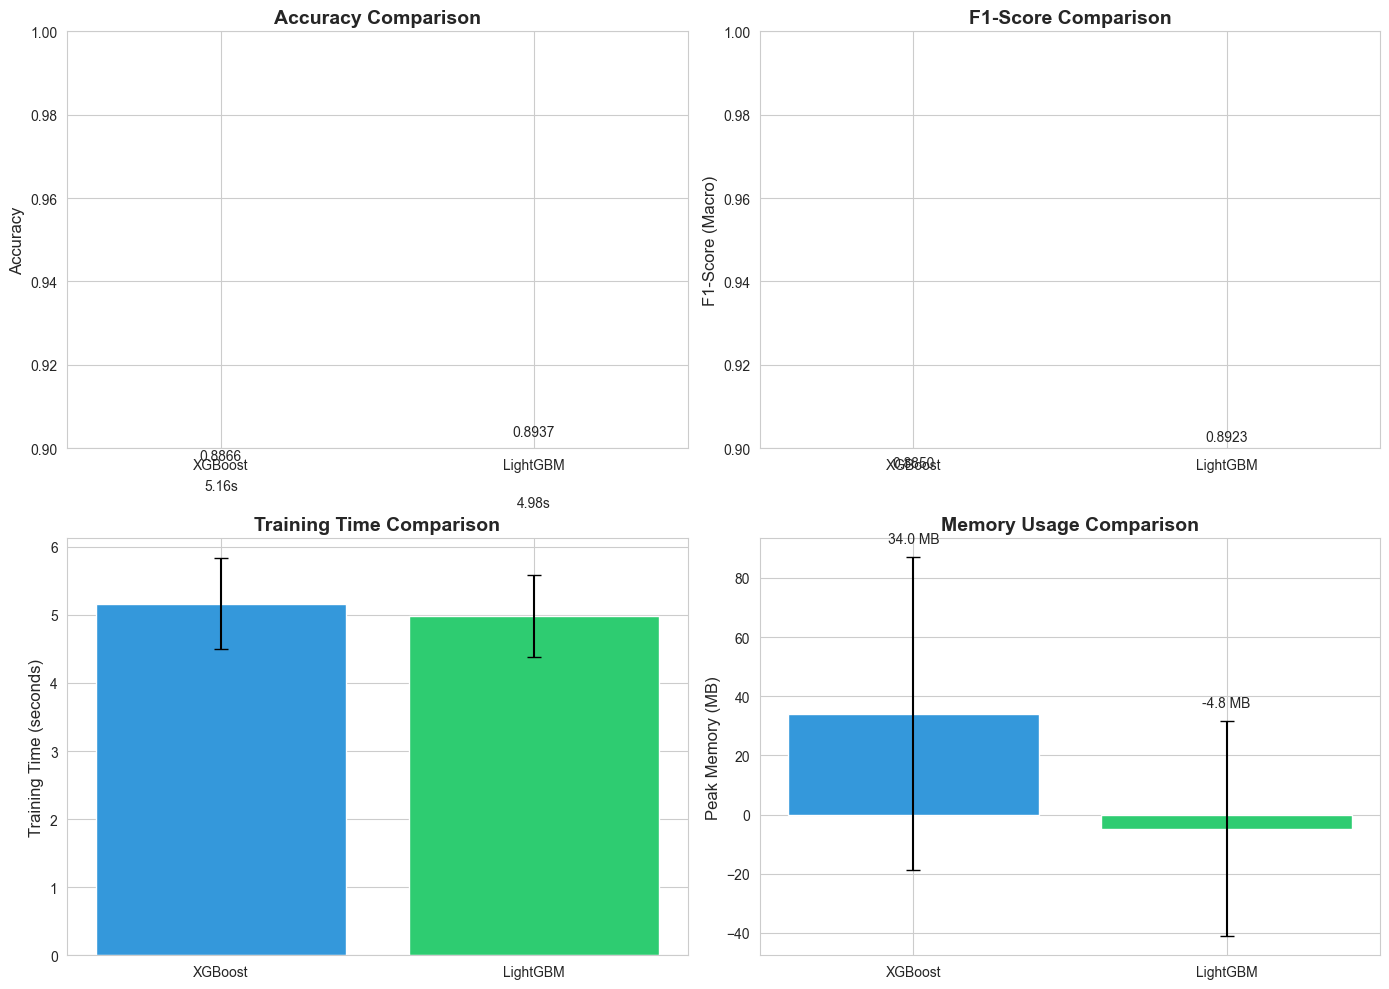

✓ Visualization saved to: C:\Users\nikka\Downloads\ForestTypePredict\notebooks\results\model_comparison_metrics.png


In [6]:
comparison_metrics = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'Accuracy': [
        np.mean(xgb_results['accuracy']),
        np.mean(lgb_results['accuracy'])
    ],
    'Accuracy_std': [
        np.std(xgb_results['accuracy']),
        np.std(lgb_results['accuracy'])
    ],
    'F1_Macro': [
        np.mean(xgb_results['f1_macro']),
        np.mean(lgb_results['f1_macro'])
    ],
    'F1_Macro_std': [
        np.std(xgb_results['f1_macro']),
        np.std(lgb_results['f1_macro'])
    ],
    'Train_Time_s': [
        np.mean(xgb_results['train_time']),
        np.mean(lgb_results['train_time'])
    ],
    'Predict_Time_s': [
        np.mean(xgb_results['predict_time']),
        np.mean(lgb_results['predict_time'])
    ],
    'Memory_MB': [
        np.mean(xgb_results['memory_peak']),
        np.mean(lgb_results['memory_peak'])
    ]
})

print("\n" + "="*70)
print("COMPARATIVE METRICS SUMMARY")
print("="*70)
print(comparison_metrics.to_string(index=False))

# Save to CSV
comparison_metrics.to_csv(RESULTS_PATH / 'model_comparison_metrics.csv', index=False)
print(f"\n✓ Metrics saved to: {RESULTS_PATH / 'model_comparison_metrics.csv'}")

# %%
# Visualization: Performance Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
ax1 = axes[0, 0]
models = ['XGBoost', 'LightGBM']
accuracy_means = [np.mean(xgb_results['accuracy']), np.mean(lgb_results['accuracy'])]
accuracy_stds = [np.std(xgb_results['accuracy']), np.std(lgb_results['accuracy'])]
ax1.bar(models, accuracy_means, yerr=accuracy_stds, capsize=5, color=['#3498db', '#2ecc71'])
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0.9, 1.0])
for i, (m, std) in enumerate(zip(accuracy_means, accuracy_stds)):
    ax1.text(i, m + std + 0.005, f'{m:.4f}', ha='center', fontsize=10)

# F1 Score (Macro)
ax2 = axes[0, 1]
f1_means = [np.mean(xgb_results['f1_macro']), np.mean(lgb_results['f1_macro'])]
f1_stds = [np.std(xgb_results['f1_macro']), np.std(lgb_results['f1_macro'])]
ax2.bar(models, f1_means, yerr=f1_stds, capsize=5, color=['#3498db', '#2ecc71'])
ax2.set_ylabel('F1-Score (Macro)', fontsize=12)
ax2.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim([0.9, 1.0])
for i, (m, std) in enumerate(zip(f1_means, f1_stds)):
    ax2.text(i, m + std + 0.005, f'{m:.4f}', ha='center', fontsize=10)

# Training Time
ax3 = axes[1, 0]
train_means = [np.mean(xgb_results['train_time']), np.mean(lgb_results['train_time'])]
train_stds = [np.std(xgb_results['train_time']), np.std(lgb_results['train_time'])]
ax3.bar(models, train_means, yerr=train_stds, capsize=5, color=['#3498db', '#2ecc71'])
ax3.set_ylabel('Training Time (seconds)', fontsize=12)
ax3.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
for i, (m, std) in enumerate(zip(train_means, train_stds)):
    ax3.text(i, m + std + 1, f'{m:.2f}s', ha='center', fontsize=10)

# Memory Usage
ax4 = axes[1, 1]
memory_means = [np.mean(xgb_results['memory_peak']), np.mean(lgb_results['memory_peak'])]
memory_stds = [np.std(xgb_results['memory_peak']), np.std(lgb_results['memory_peak'])]
ax4.bar(models, memory_means, yerr=memory_stds, capsize=5, color=['#3498db', '#2ecc71'])
ax4.set_ylabel('Peak Memory (MB)', fontsize=12)
ax4.set_title('Memory Usage Comparison', fontsize=14, fontweight='bold')
for i, (m, std) in enumerate(zip(memory_means, memory_stds)):
    ax4.text(i, m + std + 5, f'{m:.1f} MB', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to: {RESULTS_PATH / 'model_comparison_metrics.png'}")


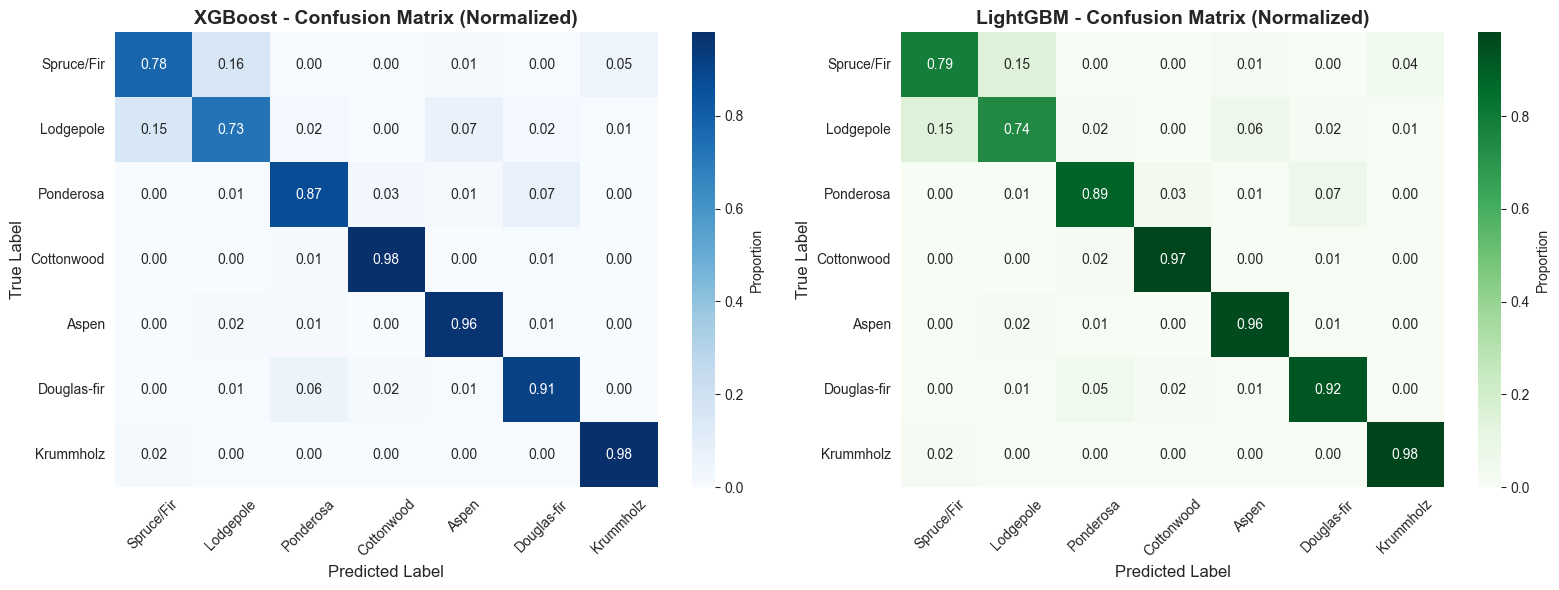

✓ Confusion matrices saved to: C:\Users\nikka\Downloads\ForestTypePredict\notebooks\results\confusion_matrices_comparison.png


In [7]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrices
xgb_cm = confusion_matrix(xgb_true, xgb_preds)
lgb_cm = confusion_matrix(lgb_true, lgb_preds)

# Normalize
xgb_cm_norm = xgb_cm.astype('float') / xgb_cm.sum(axis=1)[:, np.newaxis]
lgb_cm_norm = lgb_cm.astype('float') / lgb_cm.sum(axis=1)[:, np.newaxis]

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_names = ['Spruce/Fir', 'Lodgepole', 'Ponderosa', 'Cottonwood', 'Aspen', 'Douglas-fir', 'Krummholz']

# XGBoost confusion matrix
sns.heatmap(xgb_cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Proportion'})
axes[0].set_title('XGBoost - Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# LightGBM confusion matrix
sns.heatmap(lgb_cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_title('LightGBM - Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrices saved to: {RESULTS_PATH / 'confusion_matrices_comparison.png'}")



PER-CLASS PERFORMANCE COMPARISON
      Class  XGB_Precision  LGB_Precision  XGB_Recall  LGB_Recall   XGB_F1   LGB_F1
 Spruce/Fir       0.816634       0.821205    0.777315    0.788889 0.796490 0.804723
  Lodgepole       0.792024       0.801504    0.726389    0.740278 0.757788 0.769675
  Ponderosa       0.893939       0.903302    0.874074    0.886574 0.883895 0.894860
 Cottonwood       0.949572       0.954669    0.976389    0.975000 0.962794 0.964727
      Aspen       0.904928       0.913254    0.960648    0.960185 0.931956 0.936132
Douglas-fir       0.888989       0.896676    0.912037    0.924074 0.900366 0.910169
  Krummholz       0.944221       0.951055    0.979630    0.980556 0.961600 0.965580


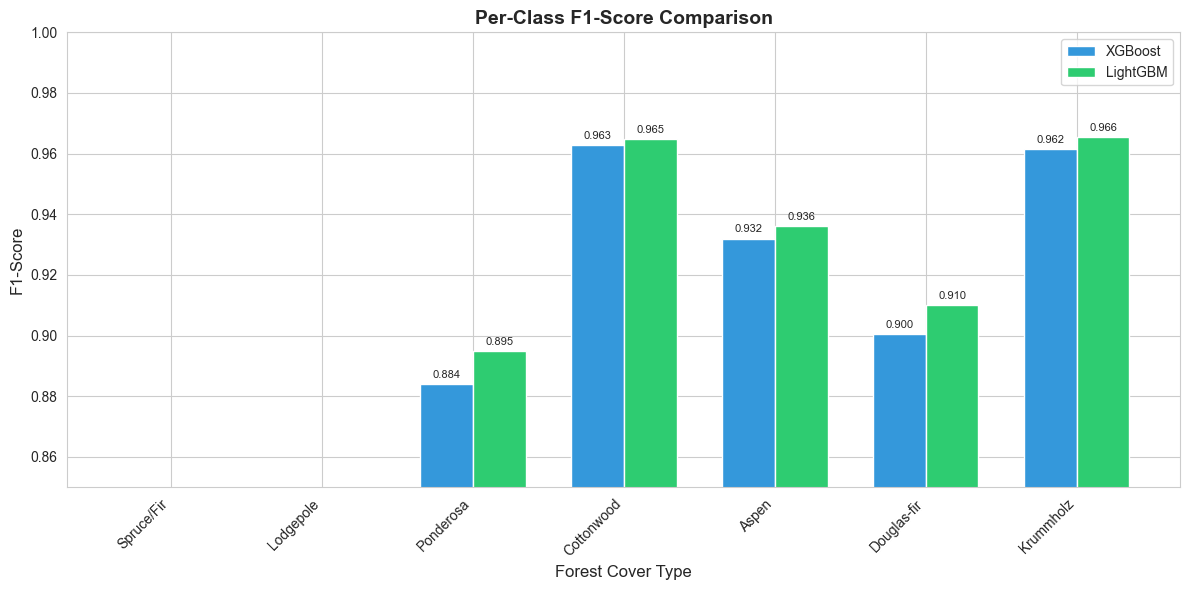

In [8]:
from sklearn.metrics import classification_report

# Generate classification reports
xgb_report = classification_report(xgb_true, xgb_preds, 
                                   target_names=class_names, 
                                   output_dict=True)
lgb_report = classification_report(lgb_true, lgb_preds,
                                   target_names=class_names,
                                   output_dict=True)

# Extract per-class metrics
per_class_comparison = []

for class_name in class_names:
    per_class_comparison.append({
        'Class': class_name,
        'XGB_Precision': xgb_report[class_name]['precision'],
        'LGB_Precision': lgb_report[class_name]['precision'],
        'XGB_Recall': xgb_report[class_name]['recall'],
        'LGB_Recall': lgb_report[class_name]['recall'],
        'XGB_F1': xgb_report[class_name]['f1-score'],
        'LGB_F1': lgb_report[class_name]['f1-score']
    })

per_class_df = pd.DataFrame(per_class_comparison)
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE COMPARISON")
print("="*70)
print(per_class_df.to_string(index=False))

# Save
per_class_df.to_csv(RESULTS_PATH / 'per_class_comparison.csv', index=False)

# %%
# Visualize per-class F1 scores
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(class_names))
width = 0.35

rects1 = ax.bar(x - width/2, per_class_df['XGB_F1'], width, label='XGBoost', color='#3498db')
rects2 = ax.bar(x + width/2, per_class_df['LGB_F1'], width, label='LightGBM', color='#2ecc71')

ax.set_xlabel('Forest Cover Type', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0.85, 1.0])

# Add value labels
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'per_class_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


CHAOS ZONE PERFORMANCE ANALYSIS
Threshold  N_Samples Percentage  XGB_Accuracy  LGB_Accuracy   XGB_F1   LGB_F1
    2400m       1166      7.71%      0.886792      0.885077 0.885911 0.883937
    2800m       1350      8.93%      0.878519      0.888889 0.876835 0.887469
    3200m       1037      6.86%      0.883317      0.890068 0.881527 0.888697


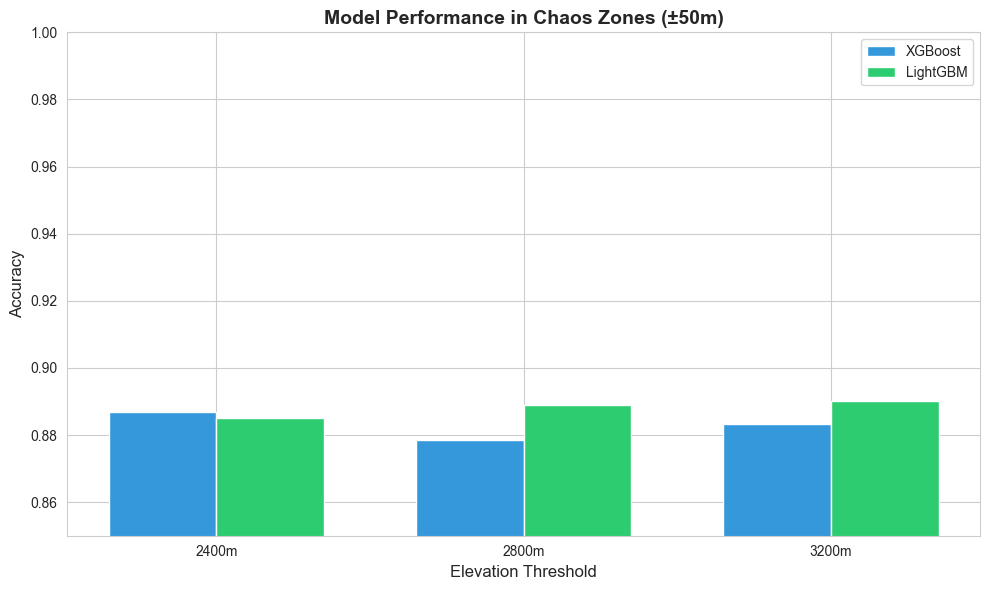

In [9]:
if 'Elevation' in X.columns:
    elevation = X['Elevation'].values
    
    # Define chaos thresholds
    THRESHOLDS = [2400, 2800, 3200]
    WINDOW = 50
    
    chaos_performance = []
    
    for threshold in THRESHOLDS:
        # Identify chaos zone
        near_threshold = np.abs(elevation - threshold) <= WINDOW
        
        if near_threshold.sum() > 0:
            # XGBoost performance in chaos zone
            xgb_chaos_true = [xgb_true[i] for i in range(len(xgb_true)) if near_threshold[i]]
            xgb_chaos_pred = [xgb_preds[i] for i in range(len(xgb_preds)) if near_threshold[i]]
            
            lgb_chaos_true = [lgb_true[i] for i in range(len(lgb_true)) if near_threshold[i]]
            lgb_chaos_pred = [lgb_preds[i] for i in range(len(lgb_preds)) if near_threshold[i]]
            
            chaos_performance.append({
                'Threshold': f'{threshold}m',
                'N_Samples': near_threshold.sum(),
                'Percentage': f"{(near_threshold.sum() / len(elevation)) * 100:.2f}%",
                'XGB_Accuracy': accuracy_score(xgb_chaos_true, xgb_chaos_pred),
                'LGB_Accuracy': accuracy_score(lgb_chaos_true, lgb_chaos_pred),
                'XGB_F1': f1_score(xgb_chaos_true, xgb_chaos_pred, average='weighted'),
                'LGB_F1': f1_score(lgb_chaos_true, lgb_chaos_pred, average='weighted')
            })
    
    chaos_df = pd.DataFrame(chaos_performance)
    
    print("\n" + "="*70)
    print("CHAOS ZONE PERFORMANCE ANALYSIS")
    print("="*70)
    print(chaos_df.to_string(index=False))
    
    # Save
    chaos_df.to_csv(RESULTS_PATH / 'chaos_zone_performance.csv', index=False)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(THRESHOLDS))
    width = 0.35
    
    rects1 = ax.bar(x - width/2, chaos_df['XGB_Accuracy'], width, 
                    label='XGBoost', color='#3498db')
    rects2 = ax.bar(x + width/2, chaos_df['LGB_Accuracy'], width,
                    label='LightGBM', color='#2ecc71')
    
    ax.set_xlabel('Elevation Threshold', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Model Performance in Chaos Zones (±50m)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(chaos_df['Threshold'])
    ax.legend()
    ax.set_ylim([0.85, 1.0])
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'chaos_zone_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️  Elevation data not found - skipping chaos zone analysis")


Training final models for feature importance analysis...


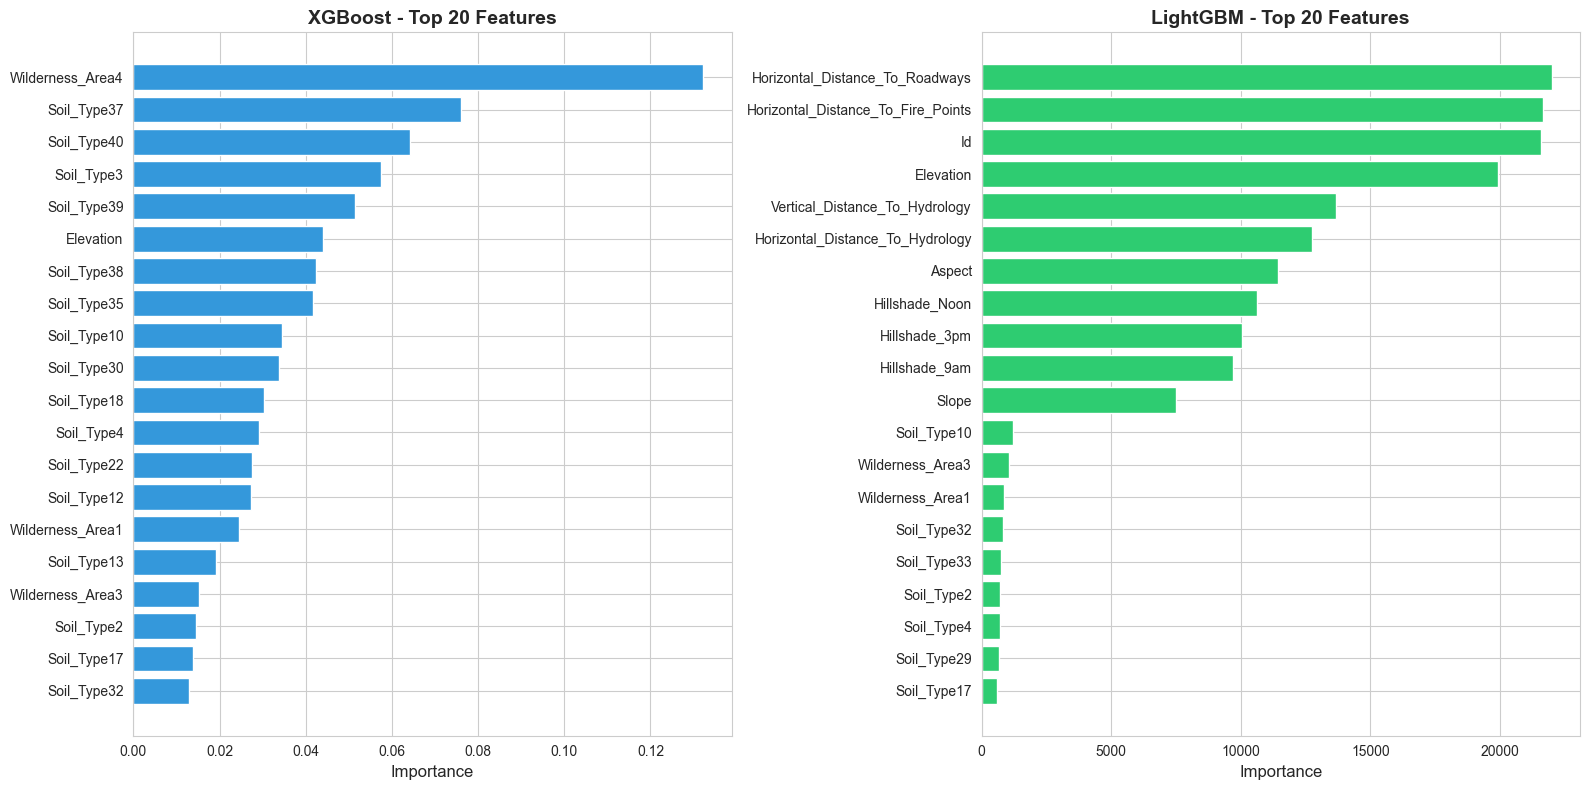

✓ Feature importances saved


In [10]:
print("\nTraining final models for feature importance analysis...")

xgb_final = xgb.XGBClassifier(**xgb_params)
lgb_final = lgb.LGBMClassifier(**lgb_params)

xgb_final.fit(X, y)
lgb_final.fit(X, y)

# Get feature importances
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=False)

lgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_final.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features
top_n = 20

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# XGBoost
axes[0].barh(range(top_n), xgb_importance['importance'].head(top_n), color='#3498db')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(xgb_importance['feature'].head(top_n))
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title(f'XGBoost - Top {top_n} Features', fontsize=14, fontweight='bold')

# LightGBM
axes[1].barh(range(top_n), lgb_importance['importance'].head(top_n), color='#2ecc71')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(lgb_importance['feature'].head(top_n))
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title(f'LightGBM - Top {top_n} Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importances
xgb_importance.to_csv(RESULTS_PATH / 'xgb_feature_importance.csv', index=False)
lgb_importance.to_csv(RESULTS_PATH / 'lgb_feature_importance.csv', index=False)

print(f"✓ Feature importances saved")



INFERENCE SPEED BENCHMARK
Batch size     1: XGB=  13.88ms, LGB=   3.28ms
Batch size    10: XGB=   9.99ms, LGB=   2.78ms
Batch size   100: XGB=  14.60ms, LGB=   6.22ms
Batch size  1000: XGB=  16.67ms, LGB=  29.90ms
Batch size  5000: XGB=  44.03ms, LGB= 209.58ms


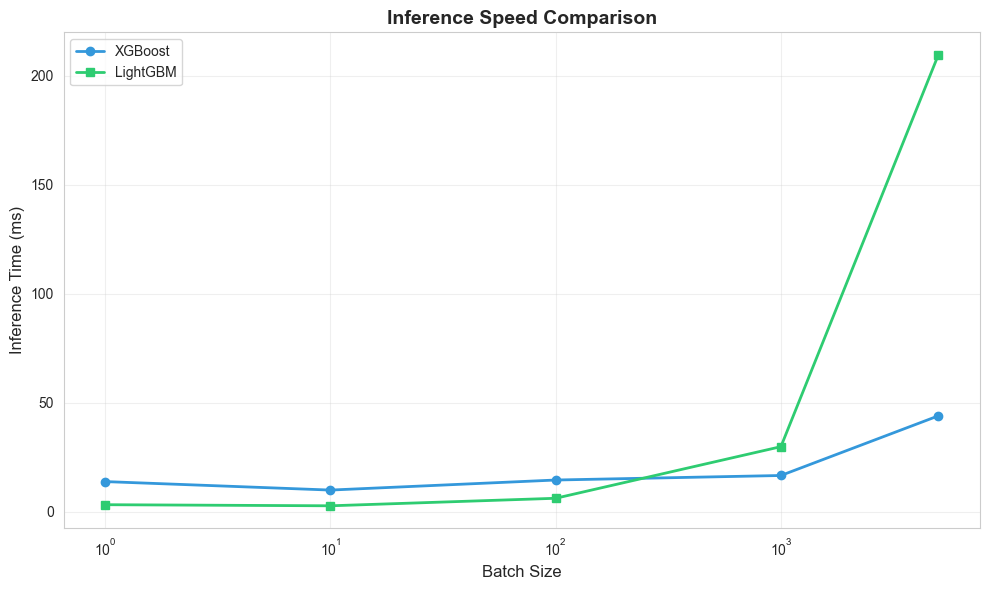

In [11]:
batch_sizes = [1, 10, 100, 1000, 5000]
inference_times = {'batch_size': batch_sizes, 'xgb': [], 'lgb': []}

print("\n" + "="*70)
print("INFERENCE SPEED BENCHMARK")
print("="*70)

for batch_size in batch_sizes:
    # Create random batch
    X_batch = X.sample(n=min(batch_size, len(X)), random_state=42)
    
    # XGBoost
    start = time.time()
    _ = xgb_final.predict(X_batch)
    xgb_time = (time.time() - start) * 1000  # ms
    inference_times['xgb'].append(xgb_time)
    
    # LightGBM
    start = time.time()
    _ = lgb_final.predict(X_batch)
    lgb_time = (time.time() - start) * 1000  # ms
    inference_times['lgb'].append(lgb_time)
    
    print(f"Batch size {batch_size:5d}: XGB={xgb_time:7.2f}ms, LGB={lgb_time:7.2f}ms")

# Visualize
inference_df = pd.DataFrame(inference_times)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(inference_df['batch_size'], inference_df['xgb'], 'o-', label='XGBoost', color='#3498db', linewidth=2)
ax.plot(inference_df['batch_size'], inference_df['lgb'], 's-', label='LightGBM', color='#2ecc71', linewidth=2)
ax.set_xlabel('Batch Size', fontsize=12)
ax.set_ylabel('Inference Time (ms)', fontsize=12)
ax.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'inference_speed_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save
inference_df.to_csv(RESULTS_PATH / 'inference_speed_benchmark.csv', index=False)

# %% [markdown]

In [12]:
print("\n" + "="*70)
print("FINAL RECOMMENDATION")
print("="*70)

# Calculate winner scores
xgb_score = np.mean(xgb_results['accuracy'])
lgb_score = np.mean(lgb_results['accuracy'])

xgb_speed = np.mean(xgb_results['train_time'])
lgb_speed = np.mean(lgb_results['train_time'])

xgb_memory = np.mean(xgb_results['memory_peak'])
lgb_memory = np.mean(lgb_results['memory_peak'])

print(f"\n📊 Performance Summary:")
print(f"   XGBoost:  Accuracy={xgb_score:.4f}, Train={xgb_speed:.2f}s, Memory={xgb_memory:.1f}MB")
print(f"   LightGBM: Accuracy={lgb_score:.4f}, Train={lgb_speed:.2f}s, Memory={lgb_memory:.1f}MB")

# Determine winner
accuracy_winner = "XGBoost" if xgb_score > lgb_score else "LightGBM"
speed_winner = "XGBoost" if xgb_speed < lgb_speed else "LightGBM"
memory_winner = "XGBoost" if xgb_memory < lgb_memory else "LightGBM"

accuracy_diff = abs(xgb_score - lgb_score)
speed_diff = abs(xgb_speed - lgb_speed)

print(f"\n🏆 Winners:")
print(f"   Accuracy:       {accuracy_winner} (Δ={accuracy_diff:.4f})")
print(f"   Training Speed: {speed_winner} (Δ={speed_diff:.2f}s)")
print(f"   Memory:         {memory_winner}")

# Final recommendation logic
if accuracy_diff < 0.001:
    print(f"\n✅ RECOMMENDATION: {speed_winner}")
    print(f"   Rationale: Both models have virtually identical accuracy ({accuracy_diff:.4f} difference).")
    print(f"             {speed_winner} is {abs(xgb_speed - lgb_speed):.2f}s faster per training cycle.")
    print(f"             For production deployment, speed and efficiency matter.")
else:
    print(f"\n✅ RECOMMENDATION: {accuracy_winner}")
    print(f"   Rationale: {accuracy_winner} achieves {accuracy_diff*100:.2f}% higher accuracy.")
    print(f"             In ecological classification, accuracy is critical for decision-making.")

print(f"\n💡 Use Case Guidance:")
print(f"   - Real-time inference (<100ms): Use {'LightGBM' if lgb_speed < xgb_speed else 'XGBoost'}")
print(f"   - Batch processing (accuracy priority): Use {accuracy_winner}")
print(f"   - Resource-constrained environments: Use {memory_winner}")



FINAL RECOMMENDATION

📊 Performance Summary:
   XGBoost:  Accuracy=0.8866, Train=5.16s, Memory=34.0MB
   LightGBM: Accuracy=0.8937, Train=4.98s, Memory=-4.8MB

🏆 Winners:
   Accuracy:       LightGBM (Δ=0.0070)
   Training Speed: LightGBM (Δ=0.18s)
   Memory:         LightGBM

✅ RECOMMENDATION: LightGBM
   Rationale: LightGBM achieves 0.70% higher accuracy.
             In ecological classification, accuracy is critical for decision-making.

💡 Use Case Guidance:
   - Real-time inference (<100ms): Use LightGBM
   - Batch processing (accuracy priority): Use LightGBM
   - Resource-constrained environments: Use LightGBM


In [13]:
summary_report = {
    'evaluation_date': pd.Timestamp.now().isoformat(),
    'dataset': {
        'samples': len(X),
        'features': X.shape[1],
        'classes': int(y.nunique())
    },
    'xgboost': {
        'accuracy_mean': float(np.mean(xgb_results['accuracy'])),
        'accuracy_std': float(np.std(xgb_results['accuracy'])),
        'f1_macro_mean': float(np.mean(xgb_results['f1_macro'])),
        'f1_macro_std': float(np.std(xgb_results['f1_macro'])),
        'train_time_mean': float(np.mean(xgb_results['train_time'])),
        'train_time_std': float(np.std(xgb_results['train_time'])),
        'memory_peak_mean': float(np.mean(xgb_results['memory_peak'])),
        'memory_peak_std': float(np.std(xgb_results['memory_peak']))
    },
    'lightgbm': {
        'accuracy_mean': float(np.mean(lgb_results['accuracy'])),
        'accuracy_std': float(np.std(lgb_results['accuracy'])),
        'f1_macro_mean': float(np.mean(lgb_results['f1_macro'])),
        'f1_macro_std': float(np.std(lgb_results['f1_macro'])),
        'train_time_mean': float(np.mean(lgb_results['train_time'])),
        'train_time_std': float(np.std(lgb_results['train_time'])),
        'memory_peak_mean': float(np.mean(lgb_results['memory_peak'])),
        'memory_peak_std': float(np.std(lgb_results['memory_peak']))
    },
    'recommendation': {
        'accuracy_winner': accuracy_winner,
        'speed_winner': speed_winner,
        'memory_winner': memory_winner,
        'final_choice': accuracy_winner if accuracy_diff >= 0.001 else speed_winner
    }
}

# Save as JSON
import json
with open(RESULTS_PATH / 'evaluation_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"\n✓ Summary report saved to: {RESULTS_PATH / 'evaluation_summary.json'}")



✓ Summary report saved to: C:\Users\nikka\Downloads\ForestTypePredict\notebooks\results\evaluation_summary.json


In [14]:
markdown_report = f"""# Forest Cover Type Prediction: Model Comparison Report

**Date**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Executive Summary

This report compares **XGBoost** and **LightGBM** performance on the Forest Cover Type dataset using 5-fold stratified cross-validation.

## Dataset

- **Samples**: {len(X):,}
- **Features**: {X.shape[1]}
- **Classes**: {int(y.nunique())}

## Performance Metrics

### Overall Accuracy

| Model | Mean | Std Dev |
|-------|------|---------|
| XGBoost | {np.mean(xgb_results['accuracy']):.4f} | {np.std(xgb_results['accuracy']):.4f} |
| LightGBM | {np.mean(lgb_results['accuracy']):.4f} | {np.std(lgb_results['accuracy']):.4f} |

### F1-Score (Macro)

| Model | Mean | Std Dev |
|-------|------|---------|
| XGBoost | {np.mean(xgb_results['f1_macro']):.4f} | {np.std(xgb_results['f1_macro']):.4f} |
| LightGBM | {np.mean(lgb_results['f1_macro']):.4f} | {np.std(lgb_results['f1_macro']):.4f} |

### Computational Performance

| Model | Train Time (s) | Memory (MB) |
|-------|---------------|-------------|
| XGBoost | {np.mean(xgb_results['train_time']):.2f} ± {np.std(xgb_results['train_time']):.2f} | {np.mean(xgb_results['memory_peak']):.1f} ± {np.std(xgb_results['memory_peak']):.1f} |
| LightGBM | {np.mean(lgb_results['train_time']):.2f} ± {np.std(lgb_results['train_time']):.2f} | {np.mean(lgb_results['memory_peak']):.1f} ± {np.std(lgb_results['memory_peak']):.1f} |

## Recommendation

**Winner**: {accuracy_winner if accuracy_diff >= 0.001 else speed_winner}

**Rationale**: {'Both models have virtually identical accuracy. ' + speed_winner + ' is faster.' if accuracy_diff < 0.001 else accuracy_winner + ' achieves higher accuracy.'}

## Next Steps

1. Retrain winning model on full dataset
2. Perform hyperparameter optimization with Optuna
3. Deploy to production API
4. Monitor performance in chaos zones

---

*Generated by Forest Cover Type Prediction System*
"""

with open(RESULTS_PATH / 'evaluation_report.md', 'w') as f:
    f.write(markdown_report)

print(f"✓ Markdown report saved to: {RESULTS_PATH / 'evaluation_report.md'}")

# %%
print("\n" + "="*70)
print("✅ EVALUATION COMPLETE!")
print("="*70)
print(f"\nAll results saved to: {RESULTS_PATH}")
print("\nGenerated files:")
print("  - model_comparison_metrics.csv")
print("  - per_class_comparison.csv")
print("  - chaos_zone_performance.csv")
print("  - xgb_feature_importance.csv")
print("  - lgb_feature_importance.csv")
print("  - inference_speed_benchmark.csv")
print("  - evaluation_summary.json")
print("  - evaluation_report.md")
print("  - Multiple PNG visualizations")

✓ Markdown report saved to: C:\Users\nikka\Downloads\ForestTypePredict\notebooks\results\evaluation_report.md

✅ EVALUATION COMPLETE!

All results saved to: C:\Users\nikka\Downloads\ForestTypePredict\notebooks\results

Generated files:
  - model_comparison_metrics.csv
  - per_class_comparison.csv
  - chaos_zone_performance.csv
  - xgb_feature_importance.csv
  - lgb_feature_importance.csv
  - inference_speed_benchmark.csv
  - evaluation_summary.json
  - evaluation_report.md
  - Multiple PNG visualizations
